In [1]:
import math
import os
import sys
import torch
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (for 3d projection)
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import torchvision.transforms as T
sys.path.append("..")
from source.utils import load_scene

class ImageSampler:
    def __init__(
        self,
        transforms_json: str,
        image_dir: str,
        width: int,
        height: int,
        total_iters: int,
        device: str = "cuda",
    ):
        # 1. Load scene metadata
        file_paths, c2w_all, K = load_scene(transforms_json, width, height, device)
        self.device = device
        self.K = K.to(device)

        # 2. Store camera-to-world matrices
        self.c2w_all = c2w_all.to(device)  # (N,4,4)

        # 2a. Extract camera origins P and viewing directions N
        P = self.c2w_all[:, :3, 3]              # (N,3)
        N = -self.c2w_all[:, :3, 2]             # (N,3)

        # 2b. Compute scene center by least-squares intersection of camera rays
        # Solve: sum_i (I - N_i N_i^T) X = sum_i (I - N_i N_i^T) P_i
        I = torch.eye(3, device=P.device, dtype=P.dtype)
        A = torch.zeros((3, 3), device=P.device, dtype=P.dtype)
        b = torch.zeros((3,),    device=P.device, dtype=P.dtype)
        for i in range(P.shape[0]):
            n_i = N[i].unsqueeze(1)             # (3,1)
            M_i = I - n_i @ n_i.T               # (3,3)
            A += M_i
            b += (M_i @ P[i])
        # Solve linear system
        center = torch.linalg.solve(A, b)       # (3,)
        self.scene_center = center.cpu().numpy()

        # 2c. Precompute world-to-camera for rendering
        self.w2c_all = torch.linalg.inv(self.c2w_all)

        # 3. Preload & resize all images
        to_tensor = T.ToTensor()
        self.images = []
        for fp in file_paths:
            cleaned = fp.lstrip("./")
            rel_dir, stem = os.path.split(cleaned)
            base_dir = os.path.join(image_dir, rel_dir)

            # try common extensions
            for ext in [".png", ".jpg", ".jpeg"]:
                candidate = os.path.join(base_dir, stem + ext)
                if os.path.exists(candidate):
                    img = Image.open(candidate).convert("RGB")
                    break
            else:
                raise FileNotFoundError(
                    f"Could not find any of {stem} in {base_dir} with .png/.jpg/.jpeg"
                )

            t = to_tensor(img).unsqueeze(0).to(device)
            t = torch.nn.functional.interpolate(
                t, size=(height, width), mode="bilinear"
            )
            self.images.append(t)

        # 4. Build fixed schedule of length total_iters
        num_images = len(self.images)
        repeats = math.ceil(total_iters / num_images)
        schedule = torch.arange(num_images, device=device).repeat_interleave(repeats)
        self.schedule = schedule[:total_iters]

    def sample(self, it: int):
        """
        On iteration `it` return:
          - target_rgb: (1,3,H,W)
          - K:         (3,3)
          - w2c:       (4,4)
        """
        idx = int(self.schedule[it])
        return self.images[idx], self.K, self.w2c_all[idx]

    def plot_camera_poses(
        self,
        arrow_length: float = 0.5,
        cube_size: float = None
    ):
        """
        Plot 3D camera positions with view normals and optional cube.

        Args:
            arrow_length: arrow length for view normals.
            cube_size: if set, draws a cube of side cube_size whose center sits
                       at the computed scene_center.
        Returns:
            fig, ax: Matplotlib Figure and 3D Axes.
        """
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot camera origins
        pos = self.c2w_all[:, :3, 3].cpu().numpy()
        ax.scatter(pos[:,0], pos[:,1], pos[:,2], c='red', s=30, label='Cameras')

        # Plot view normals
        normals = -self.c2w_all[:, :3, 2].cpu().numpy()
        for p, n in zip(pos, normals):
            ax.quiver(
                p[0], p[1], p[2],
                n[0], n[1], n[2],
                length=arrow_length, normalize=True,
                color='blue', linewidth=1
            )

        # Draw cube at scene_center
        if cube_size is not None:
            cx, cy, cz = self.scene_center
            half = cube_size / 2.0
            vertices = np.array([
                [cx-half, cy-half, cz-half],
                [cx+half, cy-half, cz-half],
                [cx+half, cy+half, cz-half],
                [cx-half, cy+half, cz-half],
                [cx-half, cy-half, cz+half],
                [cx+half, cy-half, cz+half],
                [cx+half, cy+half, cz+half],
                [cx-half, cy+half, cz+half],
            ])
            faces = [
                [0,1,2,3], [4,5,6,7],
                [0,1,5,4], [1,2,6,5],
                [2,3,7,6], [3,0,4,7]
            ]
            face_verts = [[vertices[idx] for idx in face] for face in faces]
            poly = Poly3DCollection(face_verts, alpha=0.3, facecolor='cyan', edgecolor='k', label='Object')
            ax.add_collection3d(poly)

        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.legend()

        # Equal aspect
        max_range = (pos.max(axis=0) - pos.min(axis=0)).max() / 2.0
        mid = pos.mean(axis=0)
        ax.set_xlim(mid[0]-max_range, mid[0]+max_range)
        ax.set_ylim(mid[1]-max_range, mid[1]+max_range)
        ax.set_zlim(mid[2]-max_range, mid[2]+max_range)

        plt.show()
        return fig, ax

In [ ]:
W, H = 224, 224
TOTAL_ITERS = 2001
DEVICE = "cuda"

data = 'ficus'
# 1) Instantiate your sampler (it will load the JSON, images, intrinsics, poses)
sampler = ImageSampler(
    transforms_json="../data/{}/transforms_train.json".format(data),
    image_dir="../data/{}".format(data),
    width=W,
    height=H,
    total_iters=TOTAL_ITERS,
    device=DEVICE,
)


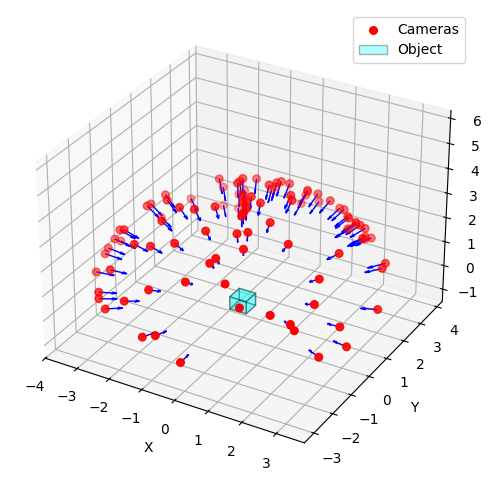

(<Figure size 600x600 with 1 Axes>,
 <Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>)

In [3]:
sampler.plot_camera_poses(arrow_length=0.5,
                          cube_size=0.5)